# Convolutional Neural Networks

## Project: Dog Breed Classification App 

---
### Why We're Here 

Given an image of a dog, a Convolutional Neural Network (CNN) is trained to provide an estimate of the canine’s breed.  If supplied an image of a human, the code will identify the resembling dog breed.
Can be used within a web or mobile app to process real-world, user-supplied images.
The image below displays potential sample output of your finished project.

![Sample Dog Output](images/sample_dog_output.png)

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.


* [Step 0](#step-1): Libraries
* [Step 1](#step0): To retrain the CNNs -> Import Datasets 
* [Step 2](#step1): Detect Humans
* [Step 3](#step2): Detect Dogs
* [Step 4](#step3): Train a CNN to Classify Dog Breeds (from Scratch)
* [Step 5](#step4): Train a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step5): Use saved model to predict Dog Breeds

---
<a id='step-1'></a>
## Step 0: Libraries

Make sure that you've downloaded the following libraries:

In [ ]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 
from tqdm import tqdm
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

<a id='step0'></a>
## Step 1: To train the CNNs -> Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [9]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 0 total human images.
There are 0 total dog images.


<a id='step1'></a>
## Step 2: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Can use the code cell below to test the performance of the `face_detector` function.

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_face_detected = 0
dog_face_detected = 0


for human in human_files_short:
    if face_detector(human):
        human_face_detected += 1

for dog in dog_files_short:
    if face_detector(dog):
        dog_face_detected += 1

print('{}% Human faces detected in human files. {}% Human faces detected in dog files.'.format(human_face_detected,dog_face_detected))

98% Human faces detected in human files. 17% Human faces detected in dog files.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).

---
<a id='step2'></a>
## Step 3: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
VGG16.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 65234786.05it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

The following function accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [6]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize(224),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    if use_cuda:
                image = image.cuda()
    # get sample outputs
    output = VGG16(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    return preds_tensor.item() # predicted class index

In [7]:
VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

252

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The `dog_detector` function below, returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
  
    return 150 < VGG16_predict(img_path) < 269 # true/false

In [9]:
dog_detector('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

True

### Assess the Dog Detector

Can use the code cell below to test the performance of your `dog_detector` function.  

0% Dogs detected in human files. 100% Dogs detected in dog files.

In [10]:
### on the images in human_files_short and dog_files_short.
def dog_detector_assessor(function):
    dog_detected_human_files = 0
    dog_detected_dog_files = 0

    for human in human_files_short:
        if function(human):
            dog_detected_human_files += 1
    for dog in dog_files_short:
        if function(dog):
            dog_detected_dog_files += 1

    print('{}% Dogs detected in human files. {}% Dogs detected in dog files.'.format(dog_detected_human_files,dog_detected_dog_files))

In [11]:
dog_detector_assessor(dog_detector)

0% Dogs detected in human files. 100% Dogs detected in dog files.


Can assess other models in a similar way. Inception v3 has been downloaded below to see if it performs better.

In [29]:
inception = models.inception_v3(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    inception = inception.cuda()

inception.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:03<00:00, 28212399.62it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [30]:
def inception_predict(img_path):
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize(299),
                        transforms.CenterCrop(299),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)
    image = image.unsqueeze(0)
    if use_cuda:
                image = image.cuda()
    # get sample outputs
    output = inception(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    return preds_tensor.item() # predicted class index

In [31]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_inception(img_path):
  
    return 150 < inception_predict(img_path) < 269 # true/false

In [32]:
dog_detector_assessor(dog_detector_inception)

1% Dogs detected in human files. 100% Dogs detected in dog files.


---
<a id='step3'></a>
## Step 4: Retrain a CNN to Classify Dog Breeds (without transfer learning)

The aim is to a achieve greater than 10% accuracy on a CNN without any pretrained weights.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
import os
from torchvision import datasets

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size = 20

train_transform = transforms.Compose([
                            transforms.RandomRotation(30),
                            transforms.RandomHorizontalFlip(),
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                 (0.229, 0.224, 0.225))])
valid_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                 (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder('/data/dog_images/train', transform=train_transform)
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform=valid_transform)
test_data = datasets.ImageFolder('/data/dog_images/test', transform=valid_transform)
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
loaders_scratch = dict()
loaders_scratch = {'train':train_loader,'valid':valid_loader, 'test':test_loader}

In [13]:
## Check train_loader has loaded the training data
len(train_loader)

334

**Preprocessing**:
To preprocess this data ahead of training I have chosen to preform the following transforms, as per the above loader:
- Resize images to 224 to make all the images the same size
- CentreCrop 224 to keep most of the image. I found that when i just used Resize transformation it produced an error stating that the resulting tensors were different sizes.
- Random Rotation of 30 degrees because some dogs have their heads tilted and it may be helpful to train the network to ignore this trend.
- Random Horizontal Flip since dogs can be positioned to either size of the image.
- Normalize the RGB values to between 0-1

### Model Architecture

See below for the CNN I created to classify dog breed, which achieved 11% accuracy. Not great.
Can adjust the model layers or add new ones. 

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3,padding=1) #16*224*224 - > 16*112*112 after maxpooling
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3,padding=1) #64*112*112 - > 16*56*56 after maxpooling
        self.conv3 = nn.Conv2d(64, 128, 3) #128*54*54 - > 128*27*27 after maxpooling
        self.fc1 = nn.Linear(128 * 27 * 27, 256)
        self.fc2 = nn.Linear(256, 133)
        #self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 128 * 27 * 27)
        x = F.relu(self.fc1(x))
        ##x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__CNN Outline:__

Large shallow layers at the start transitioning to small deeper layers. 

3 convolutional layers, 1st 2 for shapes and edges, 3rd layer for details which should help with finding the subtle distinctions betweens breeds.

I used a kernal size of 3 in the conv1 to capture more of the image detail compared to a larger kernal size, and padded the image to retain information from the edges.

I used maxpooling (2,2) to concernatrate the features from previous layers to later layers, but retain as much information as possible.

20% dropout to prevent overfitting.
After flattening I used 1 fully connected layer before a final fc to output the correct number of classes.

### Loss Function and Optimizer

Specified [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [15]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### Model Training and Validatation

[Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [26]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.867798 	Validation Loss: 4.824415
Validation loss decreased (inf --> 4.824415).  Saving model ...
Epoch: 2 	Training Loss: 4.713967 	Validation Loss: 4.695858
Validation loss decreased (4.824415 --> 4.695858).  Saving model ...
Epoch: 3 	Training Loss: 4.582115 	Validation Loss: 4.583768
Validation loss decreased (4.695858 --> 4.583768).  Saving model ...
Epoch: 4 	Training Loss: 4.426593 	Validation Loss: 4.417449
Validation loss decreased (4.583768 --> 4.417449).  Saving model ...
Epoch: 5 	Training Loss: 4.271658 	Validation Loss: 4.336050
Validation loss decreased (4.417449 --> 4.336050).  Saving model ...
Epoch: 6 	Training Loss: 4.180521 	Validation Loss: 4.296784
Validation loss decreased (4.336050 --> 4.296784).  Saving model ...
Epoch: 7 	Training Loss: 4.100271 	Validation Loss: 4.208993
Validation loss decreased (4.296784 --> 4.208993).  Saving model ...
Epoch: 8 	Training Loss: 4.036266 	Validation Loss: 4.207639
Validation loss decreased (4.20899

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.993644


Test Accuracy: 11% (94/836)


---
<a id='step4'></a>
## Step 5: CNN to Classify Dog Breeds using Transfer Learning

The CNN should attain at least 60% accuracy on the test set.

Could create new loaders for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively), but I reused the 'loaders_scratch' created for the previous model.

### Transfer Model Architecture

New model initialized as the variable `model_transfer`.

In [16]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
input = model_transfer.classifier[6].in_features
out = 133
new_layer = nn.Linear(input,out)
model_transfer.classifier[6] = new_layer
print(model_transfer.classifier[6].in_features,model_transfer.classifier[6].out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()

4096 133


__Transfer CNN Architecture:__

I used the vgg16 model as the basis for the model_transfer. This seemed like a good idea since from the earlier steps

I saw that vgg16 has trained on the Imagenet dataset which includes dog breeds, and it correctly identified the Affenpinscher_00001.jpg.

I opted to 'fine-tune' the model since the new dataset is large and similar a subset of the Imagenet data.

I loaded in vgg16 and froze the model parameters, and replaced the final layer in the classifier with a new layer the same in_features and 133 out_features.

### Loss Function and Optimizer

Specified a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Saved the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Model Training and Validatation

Train and validate your model in the code cell below at filepath `'model_transfer.pt'`.

In [37]:
# train the model
model_transfer = train(20, loaders_scratch, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 3.919897 	Validation Loss: 2.313615
Validation loss decreased (inf --> 2.313615).  Saving model ...
Epoch: 2 	Training Loss: 1.835029 	Validation Loss: 0.952747
Validation loss decreased (2.313615 --> 0.952747).  Saving model ...
Epoch: 3 	Training Loss: 1.106512 	Validation Loss: 0.650621
Validation loss decreased (0.952747 --> 0.650621).  Saving model ...
Epoch: 4 	Training Loss: 0.864954 	Validation Loss: 0.546995
Validation loss decreased (0.650621 --> 0.546995).  Saving model ...
Epoch: 5 	Training Loss: 0.744069 	Validation Loss: 0.482283
Validation loss decreased (0.546995 --> 0.482283).  Saving model ...
Epoch: 6 	Training Loss: 0.653842 	Validation Loss: 0.450177
Validation loss decreased (0.482283 --> 0.450177).  Saving model ...
Epoch: 7 	Training Loss: 0.593936 	Validation Loss: 0.423586
Validation loss decreased (0.450177 --> 0.423586).  Saving model ...
Epoch: 8 	Training Loss: 0.548566 	Validation Loss: 0.417037
Validation loss decreased (0.42358

In [23]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model

Try out your model on the test dataset of dog images. 
The code cell below calculates and prints the test loss and accuracy.  My latest model achieves 87%.

In [24]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.416426


Test Accuracy: 87% (731/836)


### Predict Dog Breed with the Model

The below function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the transfer model.  

In [25]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.Resize(224),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    if use_cuda:
                image = image.cuda()
    
    output = model_transfer(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    return class_names[preds_tensor.item()]

In [26]:
predict_breed_transfer('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

'Affenpinscher'

---
<a id='step5'></a>
## Step 6: Dog and Human Prediction Algorithm

The algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

Used the `face_detector` and `dog_detector` functions developed above as a starting point. 

In [27]:
### Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    # extract pre-trained face detector
    title = ''
    subtitle = ''
    if dog_detector(img_path):
        title = 'Hello Doggy'
        subtitle = 'This is a ' + predict_breed_transfer(img_path)
    else:
        if face_detector(img_path):
            title = 'Hello Human'
            subtitle = 'You look like a ' + predict_breed_transfer(img_path)
        else:
            title = 'Error: No Human or Dog detected'
            
    img = cv2.imread(img_path)
    print(title)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    print(subtitle)
    print('\n')

Hello Human


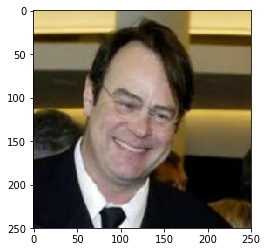

You look like a Brittany


Hello Doggy


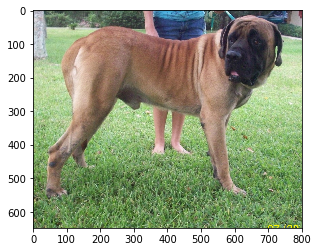

This is a Bullmastiff




In [28]:
run_app(human_files[0])
run_app(dog_files[0])

---
<a id='step6'></a>
## Test the Algorithm

In this section, take the above algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images. 

__Possible areas of improvement:__ 

I expected the model to have difficulty distinguishing a cat or wolf from a dog but it was able to say that they were not dogs. Probably because the VGG16 model included cats and dogs in it's training data.

1st area of improvement would be to include a classification of the image in the error message.

2nd improvement would be to take the user's or pet's name and include that in the Hello message.

3rd would be to add a facility to classify multiple elements within an image. I added an image with both a dog and a human, but it only detected the dog. What if an image had mulitple dog breeds?

Hello Doggy


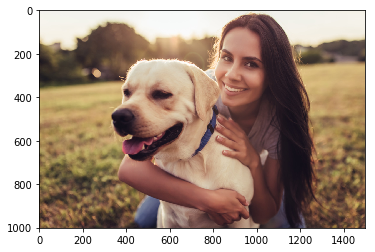

This is a Cocker spaniel


Error: No Human or Dog detected


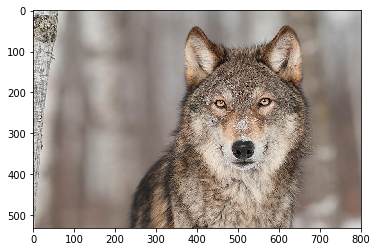




Hello Human


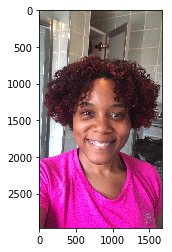

You look like a Cocker spaniel


Hello Doggy


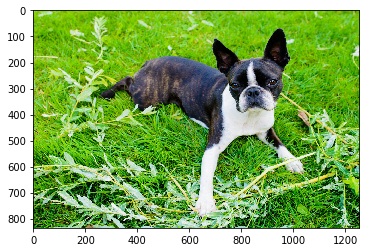

This is a Boston terrier


Hello Doggy


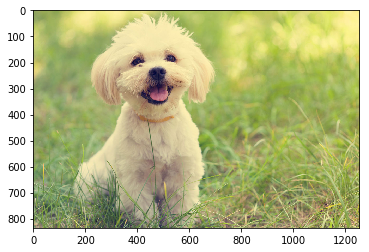

This is a Maltese


Hello Human


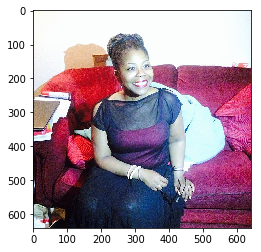

You look like a Poodle


Error: No Human or Dog detected


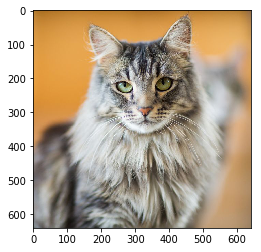

In [29]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

test_files = np.array(glob("test_images/*"))
## suggested code, below
for file in np.hstack(test_files):
    run_app(file)